In [6]:
import torch
import torchtext
import gc
import time
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
data = load_dataset("rotten_tomatoes")
data.set_format(type="pandas")
label_names = ['neg', 'pos']

Using custom data configuration default
Reusing dataset rotten_tomatoes (C:\Users\38599\.cache\huggingface\datasets\rotten_tomatoes\default\1.0.0\40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
train = data['train'][:]
valid = data['validation'][:]
test = data['test'][:]

In [9]:
train

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


In [10]:
from torch.utils.data import Dataset
class Dataset(Dataset):
 
    def __init__(self, data):
        self.text = data['text'].values.tolist()
        self.label = data['label'].values.tolist()
 
    def __len__(self):
        return len(self.label)
   
    def __getitem__(self,idx):
        return self.label[idx], self.text[idx]

In [11]:
train_dataset = Dataset(train)
valid_dataset = Dataset(valid)
test_dataset = Dataset(test)

In [12]:
def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens + ([0]* (max_words - len(tokens))) if len(tokens) < max_words else tokens[:max_words] for tokens in X] 

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y)

In [13]:
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(build_vocabulary([train_dataset, valid_dataset]), min_freq=1, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [14]:
max_words = 25

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [15]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 50
N_layers=1

class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(label_names))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(N_layers, len(X_batch), hidden_dim))
        return self.linear(output[:,-1])

In [16]:
rnn_classifier = RNNClassifier()

In [17]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(19259, 50)
Parameters : 
torch.Size([19259, 50])

Layer : RNN(50, 50, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=2, bias=True)
Parameters : 
torch.Size([2, 50])
torch.Size([2])



In [18]:
def val_loss(model, loss_fn, val_loader):
    with torch.no_grad():
        y_shuffled, y_preds, losses = [],[],[]
        for X, y in val_loader:
            preds = model(X)
            
            loss = loss_fn(preds, y)
            losses.append(loss.item())

            y_shuffled.append(y)
            y_preds.append(preds.argmax(dim=-1))

        y_shuffled = torch.cat(y_shuffled)
        y_preds = torch.cat(y_preds)

        print("val loss : {:.4f}".format(torch.tensor(losses).mean()))


def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    start_time = time.time()
    for i in range(1, epochs+1):
        print(f"Epoch: {i}")
        losses = []
        for X, y in tqdm(train_loader, desc='Training'):
            y_preds = model(X)
    
            loss = loss_fn(y_preds, y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("train loss: {:.4f}".format(torch.tensor(losses).mean()))
        val_loss(model, loss_fn, val_loader)
    end_time = time.time()
    return end_time - start_time

In [65]:
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

train_model(rnn_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

Epoch: 1


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.48it/s]


train loss: 0.7012
val loss : 0.6866
Epoch: 2


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.34it/s]


train loss: 0.6943
val loss : 0.7006
Epoch: 3


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.08it/s]


train loss: 0.6911
val loss : 0.6886
Epoch: 4


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.06it/s]


train loss: 0.6892
val loss : 0.6832
Epoch: 5


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.87it/s]


train loss: 0.6873
val loss : 0.7089
Epoch: 6


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.26it/s]


train loss: 0.6842
val loss : 0.6951
Epoch: 7


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.70it/s]


train loss: 0.6821
val loss : 0.6730
Epoch: 8


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.10it/s]


train loss: 0.6794
val loss : 0.7422
Epoch: 9


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.71it/s]


train loss: 0.6787
val loss : 0.6909
Epoch: 10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.63it/s]


train loss: 0.6734
val loss : 0.6847
Epoch: 11


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.37it/s]


train loss: 0.6657
val loss : 0.6822
Epoch: 12


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.27it/s]


train loss: 0.6562
val loss : 0.7154
Epoch: 13


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.93it/s]


train loss: 0.6464
val loss : 0.6817
Epoch: 14


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.93it/s]


train loss: 0.6307
val loss : 0.7038
Epoch: 15


Training: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.84it/s]

train loss: 0.6174
val loss : 0.6874


11.208870649337769

In [66]:
def predict(model, loader):
    start_time = time.time()
    y_shuffled, y_preds = [], []
    for X, y in loader:
        preds = model(X)
        y_preds.append(preds)
        y_shuffled.append(y)
    gc.collect()
    y_preds, y_shuffled = torch.cat(y_preds), torch.cat(y_shuffled)
    end_time = time.time()
    test_time = end_time - start_time

    return y_shuffled.detach().numpy(), F.softmax(y_preds, dim=-1).argmax(dim=-1).detach().numpy(), test_time

test_true, test_pred, test_time = predict(rnn_classifier, test_loader)

In [67]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

print('classification report')
print(classification_report(test_true, test_pred, target_names=label_names, digits=4))
print(f"Testing time: {test_time}")

classification report
              precision    recall  f1-score   support

         neg     0.5776    0.6285    0.6020       533
         pos     0.5926    0.5403    0.5653       533

    accuracy                         0.5844      1066
   macro avg     0.5851    0.5844    0.5836      1066
weighted avg     0.5851    0.5844    0.5836      1066

Testing time: 0.16074395179748535


In [68]:
def plot_confusion_matrix(y_true, y_preds, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".4f", ax=ax, colorbar=False)
    plt.show()

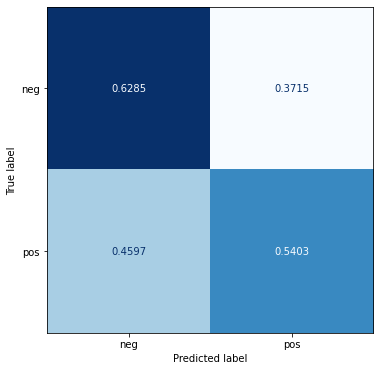

In [69]:
plot_confusion_matrix(test_true, test_pred, labels=label_names)